In [ ]:
# helper.py
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
import matplotlib.patches as mpatches

def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1


def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
# starter_kmeans

# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# For Validation set
is_valid = False
if is_valid:
  valid_batch = int(num_pts / 3.0)
  np.random.seed(45689)
  
  rnd_idx = np.arange(num_pts)
  np.random.shuffle(rnd_idx)
  val_data = data[rnd_idx[:valid_batch]]
  data = data[rnd_idx[valid_batch:]]


# Distance function for K-means
def distance_func(X, mu):
    """ Inputs:
          X: is an NxD matrix (N observations and D dimensions)
          mu: is an KxD matrix (K means and D dimensions)
          
        Output:
          pair_dist: is the squared pairwise distance matrix (NxK)
    """
    # TODO
    X_sqr = tf.reduce_sum(tf.square(X), axis=1, keepdims=False, name=None)
    X_sqr = tf.reshape(X_sqr, [-1, 1])
    
    mu_T = tf.transpose(mu)
    X_mu = tf.matmul(X, mu_T)
    
    mu_sqr = tf.reduce_sum(tf.square(mu), axis=1, keepdims=False, name=None)
    mu_sqr = tf.reshape(mu_sqr, [1, -1])
    
    pair_dist = X_sqr - 2*(X_mu) + mu_sqr

    return pair_dist

In [ ]:
def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    # TODO
    # dimension conversion
    sigma = tf.squeeze(sigma) 
    coef =  tf.log(2 * np.pi * sigma)
    exp = distance_func(X, mu) / (2 * sigma)
    dim = tf.to_float(tf.rank(X))
    gauss_pfd = (- dim / 2) * coef - exp 
    return gauss_pfd

def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    # TODO
    log_pi = tf.squeeze(log_pi)
    sum = log_PDF + tf.transpose(log_pi)
    log_sum = reduce_logsumexp(sum, reduction_indices=1, keep_dims=True)
    log_post = sum - log_sum
    return log_post

In [ ]:
def kmeans_train_loss_plot(train_loss_list):
  # train loss plot
  plt.plot(range(len(train_loss_list)),train_loss_list)
  plt.title('K-Means train loss vs number of updates')
  plt.xlabel('number of updates')
  plt.ylabel('train loss')
  plt.show()
  return

In [ ]:
def train_kmeans(k=3, epoch=500, is_valid=False):
  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    train_data = data[rnd_idx[valid_batch:]]
  else:
    train_data = data

  tf.compat.v1.reset_default_graph()
  tf.set_random_seed(421)
  
  mu = tf.get_variable("mu", initializer = tf.random.normal(shape=[k,dim]))
  X = tf.placeholder(tf.float32, shape=(None, dim), name="X")

  loss = tf.reduce_sum(tf.reduce_min(distance_func(X, mu), axis = 1))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
  
  train_loss_list = np.zeros(epoch)
  val_loss_list = np.zeros(epoch)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    for i in range(epoch):
      if is_valid:
          val_loss, val_dist, val_mu, _ = sess.run([loss, distance_func(X, mu), mu, optimizer], feed_dict = {X: val_data})
          val_loss_list[i] = val_loss

      train_loss, train_dist, train_mu, _ = sess.run([loss, distance_func(X, mu), mu, optimizer], feed_dict = {X: train_data})
      train_loss_list[i] = train_loss
      
    mu = train_mu
  
  
  return val_loss_list, train_dist, train_data, train_loss_list, mu

In [ ]:

"""
k1_val_loss = train_kmeans(k=k1, epoch=500, is_valid=False)
k2_val_loss = train_kmeans(k=k2, epoch=500, is_valid=False)
k3_val_loss = train_kmeans(k=k3, epoch=500, is_valid=False)
k4_val_loss = train_kmeans(k=k4, epoch=500, is_valid=False)
k5_val_loss = train_kmeans(k=k5, epoch=500, is_valid=False)
"""
k1_val_loss, k1_train_dist, k1_train_data, k1_train_loss_list, mu1 = train_kmeans(k=1, epoch=500, is_valid=True)
k2_val_loss, k2_train_dist, k2_train_data, k2_train_loss_list, mu2 = train_kmeans(k=2, epoch=500, is_valid=True)
k3_val_loss, k3_train_dist, k3_train_data, k3_train_loss_list, mu3 = train_kmeans(k=3, epoch=500, is_valid=True)
#k4_val_loss, k4_train_dist, k4_train_data, k4_train_loss_list, mu4 = train_kmeans(k=4, epoch=500, is_valid=True)
#k5_val_loss, k5_train_dist, k5_train_data, k5_train_loss_list, mu5 = train_kmeans(k=5, epoch=500, is_valid=True)

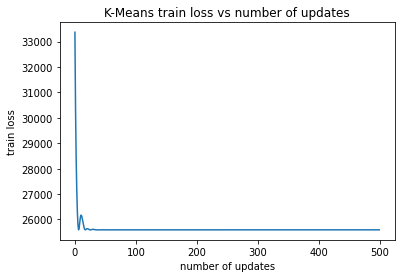

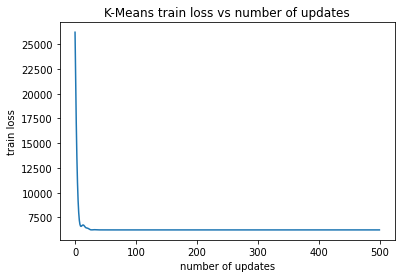

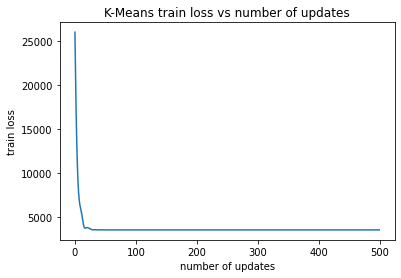

In [ ]:
kmeans_train_loss_plot(k1_train_loss_list)
kmeans_train_loss_plot(k2_train_loss_list)
kmeans_train_loss_plot(k3_train_loss_list)
#kmeans_train_loss_plot(k4_train_loss_list)
#kmeans_train_loss_plot(k5_train_loss_list)

In [ ]:
def scatter_plot(k, mu, train_dist, train_data):
  # scatter plot
  clusters = np.argmin(train_dist, axis=1)
  percentages = np.zeros(k)
  for i in range(k):
    percentages[i] = np.sum(i == clusters)*100.0/len(clusters)
    print("Class", i+1, "percentage is: ", percentages[i], "%")

  colors = np.array(["paleturquoise", "pink", "moccasin", "cornflowerblue", "lightcoral"])
  plt.scatter(mu[:, 0], mu[:, 1], marker='*', c="black")
  plt.scatter(train_data[:, 0], train_data[:, 1], c=colors[clusters])
  #plt.scatter(train_data[:, 0], train_data[:, 1], c=clusters, cmap=plt.get_cmap('Set2'))
  
  plt.title('K-Means clusters')
  plt.legend()
  plt.xlabel('x')
  plt.ylabel('y') 
  plt.grid()
  
  ls = []
  for i in range(len(mu)):
    txt = mpatches.Patch(color=colors[i],label='Class '+ str(i+1)+':' + str(round(percentages[i],1))+'%')
    ls.append(txt)
  plt.legend(handles = ls)
  
  plt.show()
  return

No handles with labels found to put in legend.


Class 1 percentage is:  100.0 %


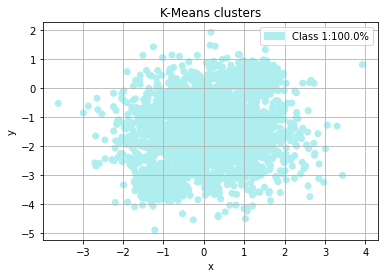

No handles with labels found to put in legend.


Class 1 percentage is:  50.24748762561872 %
Class 2 percentage is:  49.75251237438128 %


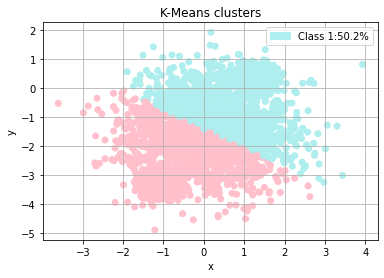

No handles with labels found to put in legend.


Class 1 percentage is:  38.3980800959952 %
Class 2 percentage is:  37.36313184340783 %
Class 3 percentage is:  24.23878806059697 %


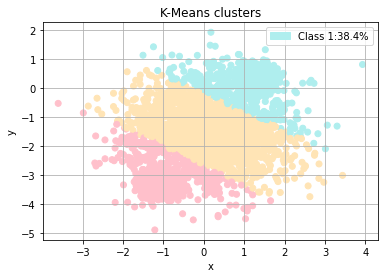

In [ ]:
scatter_plot(1, mu1, k1_train_dist, k1_train_data)
scatter_plot(2, mu1, k2_train_dist, k2_train_data)
scatter_plot(3, mu1, k3_train_dist, k3_train_data)
#scatter_plot(4, mu1, k4_train_dist, k4_train_data)
#scatter_plot(5, mu1, k5_train_dist, k5_train_data)

In [ ]:
# k1_val_loss, k2_val_loss, k3_val_loss, k4_val_loss, k5_val_loss = train_groups_of_kmeans(1, 2, 3, 4, 5)
# k5_val_loss, k10_val_loss, k15_val_loss, k20_val_loss, k30_val_loss = train_groups_of_kmeans(5, 10, 15, 20, 30)

In [ ]:
def plot_groups_of_kmeans_val_loss(k1_val_loss, k2_val_loss, k3_val_loss, k4_val_loss, k5_val_loss):
  x_range = len(k1_val_loss)
  
  plt.title('K-Means validation loss')
  plt.plot(range(x_range), k1_val_loss, label="K = 1")
  plt.plot(range(x_range), k2_val_loss, label="K = 2")
  plt.plot(range(x_range), k3_val_loss, label="K = 3")
  plt.plot(range(x_range), k4_val_loss, label="K = 4")
  plt.plot(range(x_range), k5_val_loss, label="K = 5")
  plt.xlabel('number of updates')
  plt.ylabel('validation loss')
  #plt.setp(plt.gca(), xlim = (0,1000))
  #plt.setp(plt.gca(), ylim = (69000,74000))
  plt.show()
  return 

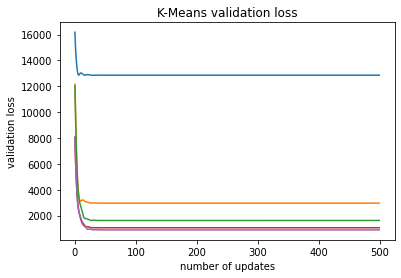

In [ ]:
plot_groups_of_kmeans_val_loss(k1_val_loss, k2_val_loss, k3_val_loss, k4_val_loss, k5_val_loss)
#plot_groups_of_kmeans_val_loss(k5_val_loss, k10_val_loss, k15_val_loss, k20_val_loss, k30_val_loss)

In [ ]:
# gmm
# Loading data
#data = np.load('data100D.npy')
data = np.load('data2D.npy')
[num_pts, dim] = np.shape(data)

def log_gauss_pdf(X, mu, sigma):
    """ Inputs: 
            X: N X D
            mu: K X D
            sigma: K X 1

        Outputs:
            log Gaussian PDF (N X K)
    """
    # TODO
    # dimension conversion
    sigma = tf.squeeze(sigma) 
    coef =  tf.log(2 * np.pi * sigma)
    exp = distance_func(X, mu) / (2 * sigma)
    dim = tf.to_float(tf.rank(X))
    gauss_pfd = (- dim / 2) * coef - exp 
    return gauss_pfd

def log_posterior(log_PDF, log_pi):
    """ Inputs:
            log_PDF: log Gaussian PDF N X K
            log_pi: K X 1

        Outputs
            log_post: N X K
    """
    # TODO
    log_pi = tf.squeeze(log_pi)
    sum = log_PDF + tf.transpose(log_pi)
    log_sum = reduce_logsumexp(sum, reduction_indices=1, keep_dims=True)
    log_post = sum - log_sum
    return log_post

In [ ]:
def train_MoG(k=3, epoch=500, is_valid=False):
  if is_valid:
    valid_batch = int(num_pts / 3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data = data[rnd_idx[:valid_batch]]
    train_data = data[rnd_idx[valid_batch:]]
  else:
    train_data = data
  
  tf.reset_default_graph() 
  tf.set_random_seed(421)
  
  mu = tf.get_variable("mu", initializer=tf.random.normal(shape=[k, dim]))
  X = tf.placeholder(tf.float32, name="X", shape=(None, dim))  
  sigma = tf.exp(tf.get_variable("sigma", initializer=tf.random.normal(shape=[k, 1])))
  
  log_gaus_pdf = log_gauss_pdf(X, mu, sigma)
  pi = tf.get_variable("pi", initializer=tf.random.normal(shape=[k, 1]))
  log_pi = tf.squeeze(logsoftmax(pi))
  log_post = log_gaus_pdf + log_pi
  
  clusters_np = np.zeros(epoch)
  clusters = tf.argmax(tf.nn.softmax(log_posterior(log_gaus_pdf, log_pi)), 1)

  loss = (-1) * tf.reduce_sum(reduce_logsumexp(log_post))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.1, beta1=0.9, beta2=0.99, epsilon=1e-5).minimize(loss)
  
  val_loss_list = np.zeros(epoch)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for i in range(epoch):
      if is_valid:
          val_loss, val_pi, val_mu, val_sigma, _, _ = sess.run([loss, pi, mu, sigma, optimizer, clusters], feed_dict={X:val_data})
          
          val_loss_list[i] = val_loss
      
      train_loss, train_pi, train_mu, train_sigma, clusters_np, _  = sess.run([loss, pi, mu, sigma, clusters, optimizer], feed_dict={X:train_data})
      
    
    mu = train_mu
 
  return val_loss_list, train_data, mu, clusters_np

In [ ]:
def scatter_plot(k, mu, clusters_np, train_data):
  # scatter plot
  percentages = np.zeros(k)
  for i in range(k):
    percentages[i] = np.sum(i == clusters_np)*100.0/len(clusters_np)
    print("Class", i+1, "percentage is: ", percentages[i], "%")
  
  plt.scatter(mu[:, 0], mu[:, 1], marker='*', c="black", cmap=plt.get_cmap('Set1'))
  colors = np.array(["paleturquoise", "pink", "moccasin", "cornflowerblue", "lightcoral"])
  plt.scatter(train_data[:, 0], train_data[:, 1], c=colors[clusters_np])
  #plt.scatter(train_data[:, 0], train_data[:, 1], c=clusters, cmap=plt.get_cmap('Set2'))
  
  plt.title('MoG clusters')
  plt.xlabel('x')
  plt.ylabel('y')

  ls = []
  for i in range(len(mu)):
    txt = mpatches.Patch(color=colors[i],label='cluster '+ str(i+1)+':' + str(round(percentages[i],1))+'%')
    ls.append(txt)
  plt.legend(handles = ls)
  return

In [ ]:
def MoG_val_loss_plot(val_loss_list):
  # validation loss plot
  plt.show()
  plt.plot(range(len(val_loss_list)), val_loss_list)
  plt.title('MoG validation loss vs number of updates')
  plt.xlabel('number of updates')
  plt.ylabel('loss')
  plt.show()
  return

In [ ]:
k1_val_loss_list, k1_train_data, mu1, cluster1 = train_MoG(k = 1, epoch = 500, is_valid = True)
#k2_val_loss_list, k2_train_data, mu2, cluster2 = train_MoG(k = 2, epoch = 500, is_valid = True)
k3_val_loss_list, k3_train_data, mu3, cluster3 = train_MoG(k = 3, epoch = 500, is_valid = True)
k4_val_loss_list, k4_train_data, mu4, cluster4 = train_MoG(k = 4, epoch = 500, is_valid = True)
#k5_val_loss_list, k5_train_data, mu5, cluster5 = train_MoG(k = 5, epoch = 500, is_valid = True)

Class 1 percentage is:  100.0 %
Class 1 percentage is:  32.8033598320084 %
Class 2 percentage is:  33.16334183290835 %
Class 3 percentage is:  34.033298335083245 %
Class 1 percentage is:  32.8033598320084 %
Class 2 percentage is:  33.85330733463327 %
Class 3 percentage is:  0.16499175041247938 %
Class 4 percentage is:  33.178341082945856 %


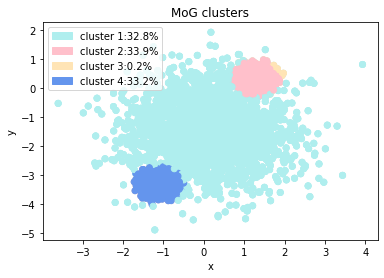

In [ ]:
scatter_plot(1, mu1, cluster1, k1_train_data)
#scatter_plot(2, mu2, cluster2, k2_train_data)
scatter_plot(3, mu3, cluster3, k3_train_data)
scatter_plot(4, mu4, cluster4, k4_train_data)
#scatter_plot(5, mu5, cluster5, k5_train_data)

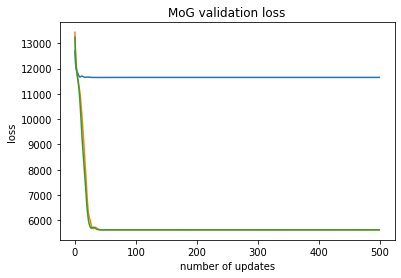

In [ ]:
x_range = len(k1_val_loss_list)
plt.plot(range(x_range), k1_val_loss_list, label="k=1")
#plt.plot(range(len(x_range)), k2_val_loss_list, label="k=2")
plt.plot(range(x_range), k3_val_loss_list, label="k=3")
plt.plot(range(x_range), k4_val_loss_list, label="k=4")
#plt.plot(range(len(x_range)), k5_val_loss_list, label="k=5")
plt.title('MoG validation loss')
plt.xlabel('number of updates')
plt.ylabel('loss')
#plt.setp(plt.gca(), ylim = (22480,22520))
plt.show()